This notebook compares several classification models on with manufacturing sensor data.
Try to detect where it failed with a multi-label classification on 5 target variables.
These Variables are:

- *TWF*: Tool Wear Failure
- *HDF*: Heat Dissipation Failed
- *PWF*: Power Failure
- *OSF*: Overstrain Failure
- *RNF*: Random Noise Failure.


In [85]:
import time

import streamlit


start = time.time()

# Suppress warnings
import warnings


warnings.filterwarnings("ignore")

# Import required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.metrics import (
    precision_score, recall_score, f1_score, make_scorer,
    confusion_matrix, precision_recall_curve
)
from sklearn.inspection import permutation_importance
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import  (
    VotingClassifier, RandomForestClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from wolta.model_tools import compare_models
from joblib import dump
import shap # https://shap.readthedocs.io/en/latest/
import json
import joblib




# Loading up the data and processing it

In [86]:
#Load the dataset
df = pd.read_csv("ai4i2020.csv")

print("Rows with nulls:", df.isna().any(axis=1).sum())


# Define dataframe columns with numeric values, columns with categories,  target columns
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']
targets = ['TWF', 'HDF', 'PWF', 'OSF']
# By dropping 'Product ID', 'UDI', 'Machine failure' with the targets we will be left with a dataframe that just contains the features
# So drop cols is a list that combines them
drop_cols = ['Product ID', 'UDI', 'Machine failure', 'RNF'] + targets

# split the dataframe in to two dataframes  one with features and anotehr with targets

modelFeatures = df.drop(columns=drop_cols)
modelTargets = df[targets]

# Create preprocessing pipeline -- https://scikit-learn.org/stable/modules/preprocessing.html

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False), categorical_features)
])


X_train, X_test, y_train, y_test = train_test_split(modelFeatures, modelTargets, test_size=0.2, random_state=42)
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
dump(preprocessor, 'preprocessor.pkl')



# Need to update the feature names list with the names of the new columns created by one hot encoding
oneHotEncodedFeatures = ['Type_H','Type_L','Type_M']
# add the one hot encoded list to the numeric list and we have our list of features
modelFeatureNames = numeric_features + oneHotEncodedFeatures


## we need to covert  X_train_proc to a dataframe so we can preview it,
tempDf = pd.DataFrame(X_train_proc, columns=modelFeatureNames)
# Print a sample of preprocessed data
print("\nPreprocessed features sample:")
print(tempDf.head())

# delete the temp dataframe, when dealing with large datasets it can help
# with memory management if you dont have large chunks of data in memeory
del tempDf

# Save the test datasets to CSV for use in other scripts
# it will enable us to get metrics from our final exported model,
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)



Rows with nulls: 0

Preprocessed features sample:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0            -0.854066                -0.609589                0.427634   
1            -0.904014                -1.080528               -0.834945   
2            -0.904014                -1.484190               -0.059677   
3             0.444571                 0.534121                0.333495   
4             0.694309                 0.332290                0.178441   

   Torque [Nm]  Tool wear [min]  Type_H  Type_L  Type_M  
0    -0.892696         1.375035     0.0     1.0     0.0  
1     1.382187         0.457620     0.0     1.0     0.0  
2    -0.892696         1.359218     0.0     1.0     0.0  
3    -0.702288        -1.598655     0.0     0.0     1.0  
4    -0.612094         1.580663     0.0     1.0     0.0  


## Feature Selection
Run an ANOVA test to see which feature has the greatest influnce on the targets

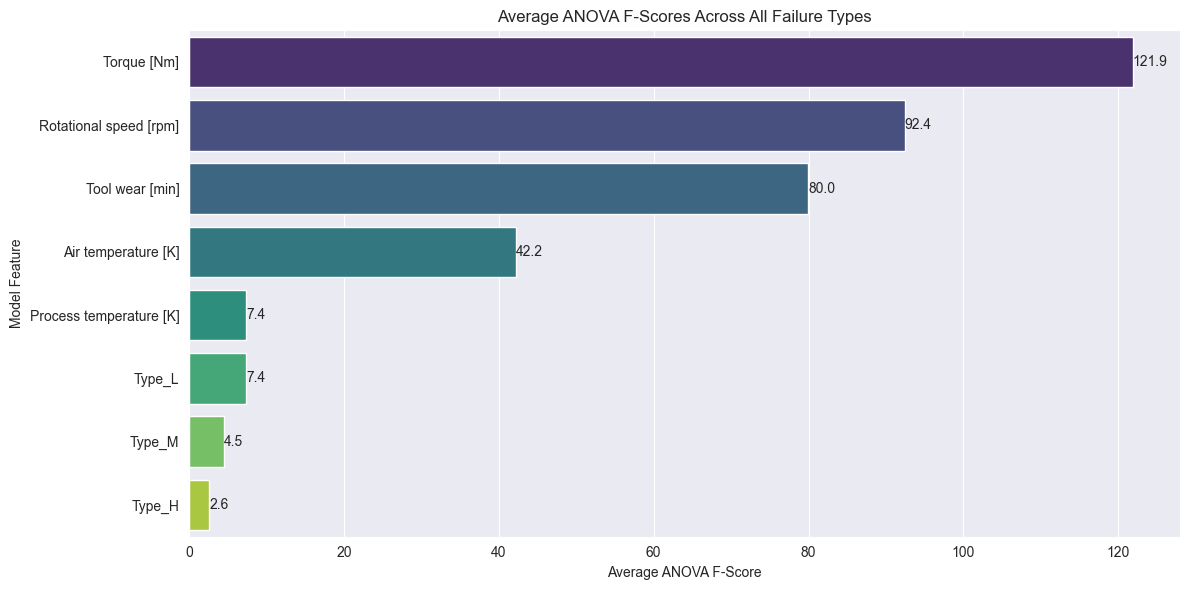

In [87]:


# Calculate average F-scores for each feature in the data set
# Uses the ANOVA F-test (`f_classif`) to score each feature against each target

avg_scores = [
    np.mean([
        SelectKBest(f_classif, k='all').fit(X_train_proc, y_train[t]).scores_[i]
        for t in targets
    ])
    for i in range(len(modelFeatureNames))
]

# Create and sort a DataFrame with the results
# Sort the dataframe by ANOVA score in descending order so we have the
# feature with the highest influence on top
scores_df = pd.DataFrame({
    'Model Feature': modelFeatureNames,
    'Average ANOVA F-Score': avg_scores
}).sort_values('Average ANOVA F-Score', ascending=False)

# Plot a bar graph with the results
plt.figure(figsize=(12, 6))
sns.barplot(data=scores_df, x='Average ANOVA F-Score', y='Model Feature', palette='viridis')
plt.title('Average ANOVA F-Scores Across All Failure Types')
plt.xlabel('Average ANOVA F-Score')
plt.ylabel('Model Feature')
#plt.savefig(f'ANOVA_F-Scores.png',dpi=600,bbox_inches='tight')

# Add feature labels labels to the chart
for i, score in enumerate(scores_df['Average ANOVA F-Score']):
    plt.text(score, i, f'{score:.1f}', va='center')

plt.tight_layout()
plt.show()

In [88]:

selector = SelectKBest(f_classif)
X_train_selected = selector.fit_transform(X_train_proc, y_train.iloc[:, 0])
X_test_selected = selector.transform(X_test_proc)

# Get selected feature names
selected_features = np.array(modelFeatureNames)[selector.get_support()].tolist()
print("Selected features:", selected_features)


Selected features: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H', 'Type_L', 'Type_M']


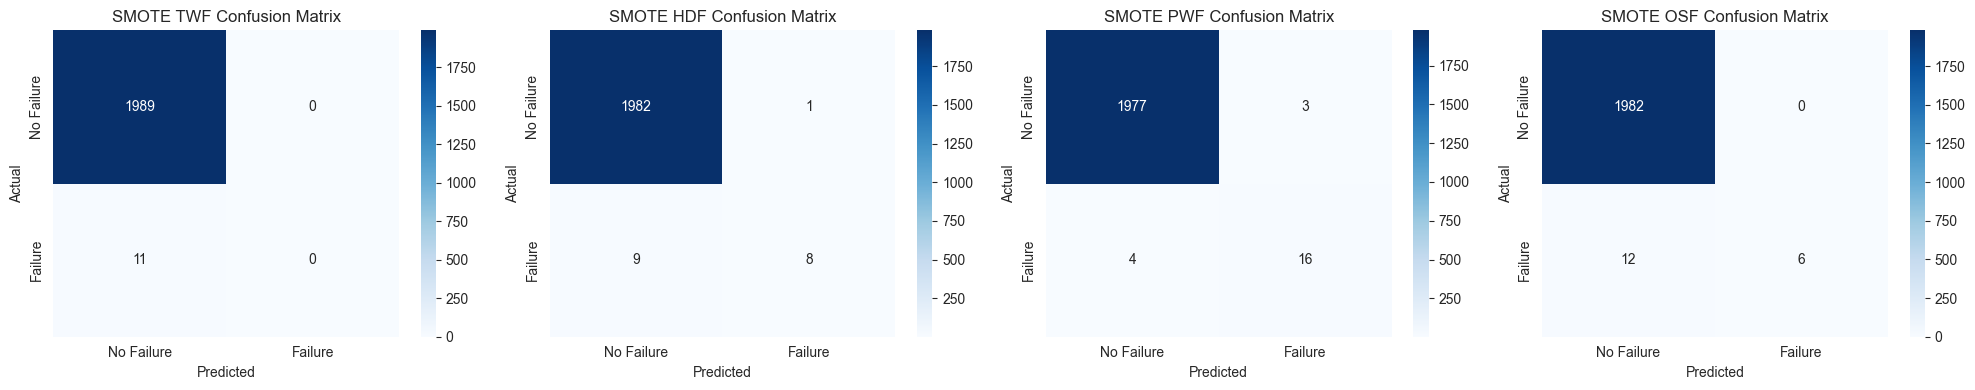

In [89]:
def draw_confusion_matrices(model, X_test, y_test, targets):

    model.fit(X_train_proc, y_train)

    y_pred = model.predict(X_test_proc)
    # Create a row of graphs, one for each target
    fig, axes = plt.subplots(1, len(targets), figsize=(5 * len(targets), 4))
    # loop through each target and generate a confusion matrix
    for i, target in enumerate(targets):
        cm = confusion_matrix(y_test[target], y_pred[:, i])
        ax = axes[i] if len(targets) > 1 else axes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Failure', 'Failure'],
                    yticklabels=['No Failure', 'Failure'],
                    ax=ax)
        ax.set(title=f'SMOTE {target} Confusion Matrix', xlabel='Predicted', ylabel='Actual')

    #plt.savefig(f'confusion_matrices.png', dpi=600,bbox_inches='tight' )
    plt.tight_layout()
    plt.show()



draw_confusion_matrices(RandomForestClassifier(random_state=42), X_test_selected, y_test, targets=['TWF', 'HDF', 'PWF', 'OSF'])

In [90]:


def train_and_evaluate_model( model, X_train, X_test, y_train,  y_test, thresholds: dict = None):


    # 1. Fit the model
    model.fit(X_train, y_train)

    # 2. Create predictions
    if thresholds:
        # multi-output predict_proba returns a list of arrays, one per target
        y_probas = model.predict_proba(X_test)

        # build a (n_samples, n_targets) array of thresholded labels
        y_pred = np.column_stack([
            (y_probas[i][:, 1] >= thresholds.get(target, 0.5)).astype(int)
            for i, target in enumerate(y_test.columns)
        ])
    else:
        # regular predict; assume returns array of shape (n_samples, n_targets)
        y_pred = model.predict(X_test)

    # 3. Measure precision / recall / f1 for each target
    results = {}
    for i, target in enumerate(y_test.columns):
        y_true_i = y_test[target].values
        y_pred_i = y_pred[:, i]

        results[target] = {
            "Precision": precision_score(y_true_i, y_pred_i),
            "Recall":    recall_score(y_true_i, y_pred_i),
            "F1-score":  f1_score(y_true_i, y_pred_i),
        }

    # 4. Return as a transposed DataFrame
    return pd.DataFrame(results).T


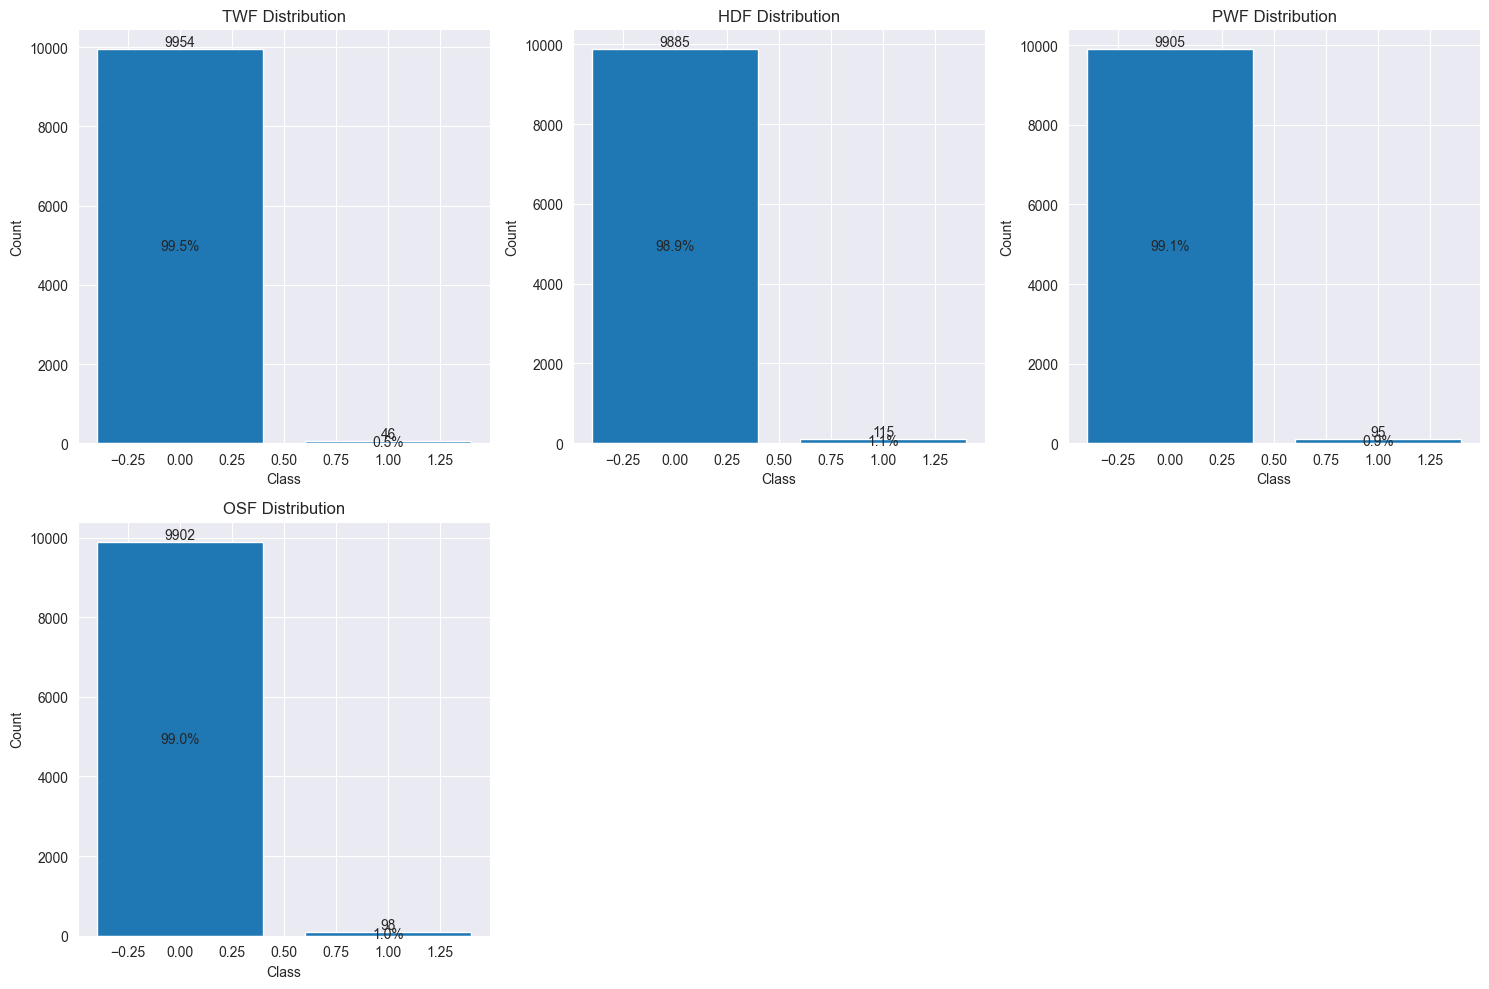


Class Balance Stats

TWF: 0s = 9954, 1s = 46, Ratio = 216.39:1

HDF: 0s = 9885, 1s = 115, Ratio = 85.96:1

PWF: 0s = 9905, 1s = 95, Ratio = 104.26:1

OSF: 0s = 9902, 1s = 98, Ratio = 101.04:1


In [91]:
def check_class_balance(y, targets):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    stats = {}

    for i, target in enumerate(targets):
        counts = y[target].value_counts()
        props = y[target].value_counts(normalize=True)
        ratio = props.get(0, 0) / props.get(1, 1e-8)


        stats[target] = {
            '0s': counts[0],
            '1s': counts.get(1, 0),
            'Ratio': ratio
        }

        ax = axes[i]
        ax.bar(counts.index, counts.values)
        ax.set(title=f'{target} Distribution', xlabel='Class', ylabel='Count')

        for j, val in enumerate(counts.values):
            ax.text(j, val, str(val), ha='center', va='bottom')
            ax.text(j, val/2, f'{props[j]:.1%}', ha='center', va='center')



    for i in range(len(targets), len(axes)):
        fig.delaxes(axes[i])

    plt.savefig(f'Balance_plots.png', dpi=600,bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    print("\nClass Balance Stats")
    for target, s in stats.items():
        print(f"\n{target}: 0s = {s['0s']}, 1s = {s['1s']}, Ratio = {s['Ratio']:.2f}:1")

y = df[['TWF', 'HDF', 'PWF', 'OSF']]
target_columns = ['TWF', 'HDF', 'PWF', 'OSF']

check_class_balance(y, target_columns)


Data is really imbalanced. Try balancing it using SMOTE and Test the scores again

In [92]:



def apply_smote_multilabel_preserve_features(X, y, seed=42):
    X_resampled_list = []
    y_resampled_list = []

    for col in y.columns:
        smote = SMOTE(random_state=seed)
        X_res, y_res = smote.fit_resample(X, y[col].fillna(0))
        X_resampled_list.append(X_res)
        y_resampled_list.append(y_res)

    # Find the smallest resampled size to align everything
    min_len = min(len(arr) for arr in X_resampled_list)

    # Stack and average features across all resampled sets
    X_stacked = np.stack([X_res[:min_len] for X_res in X_resampled_list])
    X_final = np.mean(X_stacked, axis=0)  # Averaging helps blend feature influence

    # Build final target DataFrame
    y_final = pd.DataFrame({col: y_resampled_list[i][:min_len] for i, col in enumerate(y.columns)})

    return pd.DataFrame(X_final, columns=X.columns), y_final

X_train_df = pd.DataFrame(X_train_proc, columns=modelFeatureNames)

X_train_resampled, y_train_resampled = apply_smote_multilabel_preserve_features(X_train_df, y_train)




In [93]:


def generate_metric_heatmaps_from_df(df, filename_suffix=""):
    sns.set_theme(style="white")
    metrics = ["Precision", "Recall", "F1-score"]

    for metric in metrics:
        metric_df = df[df["Metric"] == metric]
        heatmap_data = metric_df.pivot(index="Failure_Type", columns="Model", values="Value")

        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", fmt=".2f",
                    linewidths=0.5, cbar=True)

        plt.title(f"{metric} Heatmap", fontsize=14)
        plt.xlabel("Model")
        plt.ylabel("Failure Type")
        plt.tight_layout()

        filename = f"{metric}_heatmap{filename_suffix}.png"
        #plt.savefig(filename)
        #print(f"Saved: {filename}")

        # Show plot (optional)
        plt.show()



In [94]:
def plot_precision_recall_curves(model, X_test, y_test, targets):


    plt.figure(figsize=(15, 10))
    best_thresholds = {}

    probs = model.predict_proba(X_test)

    for i, target in enumerate(targets):
        y_prob = probs[i][:, 1] if isinstance(probs, list) else probs[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test[target], y_prob)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_idx = np.argmax(f1)
        best_thresholds[target] = thresholds[best_idx]
        plt.plot(recall, precision, label=f'{target} (threshold={thresholds[best_idx]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'New_Threshold_recall_curve.png', dpi=600,bbox_inches='tight')
    plt.show()

    return best_thresholds

**Use Wolta model tools to compare models to get the best persorming models**

use this list of models AdaBoost, CatBoost, LightGBM, Random Forest, Extra Tree, Decision Tree, Perceptron, Ridge, Logistic Regression, KNN, GaussianNB, and SVC

In [95]:


target_columns = ['TWF', 'HDF', 'PWF', 'OSF']
models_to_test = ['ada', 'cat', 'lbm', 'raf', 'ext', 'dtr', 'per', 'rdg','log','knn','gnb','svc']
model_metrics = {model: [] for model in models_to_test}

# Loop through each target and collect recall scores
for target in target_columns:
    results = compare_models(
        algo_type='clf',
        algorithms=models_to_test,
        metrics=['recall','precision','f1'],
        X_train=X_train_proc,
        y_train=y_train[target],
        X_test=X_test_proc,
        y_test=y_test[target],
        get_result=True
    )

    for model in models_to_test:
        recall = results.get(model, {}).get('recall', 0)
        model_metrics[model].append(recall)

#Create a leaderboard DataFrame
leaderboard = pd.DataFrame(model_metrics, index=target_columns).T
leaderboard['Avg_Recall_score'] = leaderboard.mean(axis=1)
leaderboard = leaderboard.sort_values(by='Avg_Recall_score', ascending=False)

print(leaderboard)

AdaBoost
Recall Score: 0.994
Precision Score: 0.9890275137568785
F1 Score (weighted): 0.991507522567703
***
CatBoost
Recall Score: 0.9945
Precision Score: 0.98903025
F1 Score (weighted): 0.991757583354224
***
LightGBM
Recall Score: 0.9945
Precision Score: 0.9922725225225225
F1 Score (weighted): 0.9926023615210974
***
Random Forest
Recall Score: 0.9945
Precision Score: 0.98903025
F1 Score (weighted): 0.991757583354224
***
Extra Tree
Recall Score: 0.986
Precision Score: 0.9889833585476551
F1 Score (weighted): 0.9874894259818732
***
Decision Tree
Recall Score: 0.9895
Precision Score: 0.9899558182427901
F1 Score (weighted): 0.9897269407790448
***
Perceptron
Recall Score: 0.994
Precision Score: 0.9890275137568785
F1 Score (weighted): 0.991507522567703
***
Ridge
Recall Score: 0.9945
Precision Score: 0.98903025
F1 Score (weighted): 0.991757583354224
***
Logistic Regression
Recall Score: 0.9945
Precision Score: 0.98903025
F1 Score (weighted): 0.991757583354224
***
KNN
Recall Score: 0.9945
Prec

 The Five best models are AdaBoost, catboost, LightGBM, Logisticregression and Random Forests

Create a voting classifer of Random Forests, Adaboost, cat boost, Logisticregression and LightGBM

In [96]:
# Data preprocessing specifically for LightGBM compatibility
def prepare_data_for_lightgbm(X, y):


    # Convert to numpy arrays to ensure data type consistency
    if isinstance(X, pd.DataFrame):
        X_clean = X.values.astype(np.float32)
    else:
        X_clean = np.array(X, dtype=np.float32)

    if isinstance(y, pd.DataFrame):
        y_clean = y.values.astype(np.int32)
    else:
        y_clean = np.array(y, dtype=np.int32)

    # Check for and handle NaN/infinite values
    X_clean = np.nan_to_num(X_clean, nan=0.0, posinf=1e10, neginf=-1e10)

    # Ensure no negative values in target (LightGBM requirement)
    y_clean = np.clip(y_clean, 0, None)

    return X_clean, y_clean


# Apply data preparation
X_train_clean, y_train_clean = prepare_data_for_lightgbm(X_train_resampled, y_train_resampled)
X_test_clean, _ = prepare_data_for_lightgbm(X_test_proc, y_test)


In [97]:

voting_model = MultiOutputClassifier(
    VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=500, random_state=42)),
            ('ada', AdaBoostClassifier(random_state=42)),
            ('cat', CatBoostClassifier(verbose=0, random_state=42)),
            ('lgbm', LGBMClassifier(random_state=42))
        ],
        voting='soft'  # use 'soft' to average predicted probabilities
    )
)

voting_results = train_and_evaluate_model(
    voting_model,
    X_train_clean,
    X_test_clean,
    y_train_resampled,
    y_test
)

print("\nVotingClassifier Ensemble Results:")
print(voting_results)





VotingClassifier Ensemble Results:
     Precision    Recall  F1-score
TWF   0.000000  0.000000  0.000000
HDF   0.375000  0.705882  0.489796
PWF   0.292683  0.600000  0.393443
OSF   0.393939  0.722222  0.509804


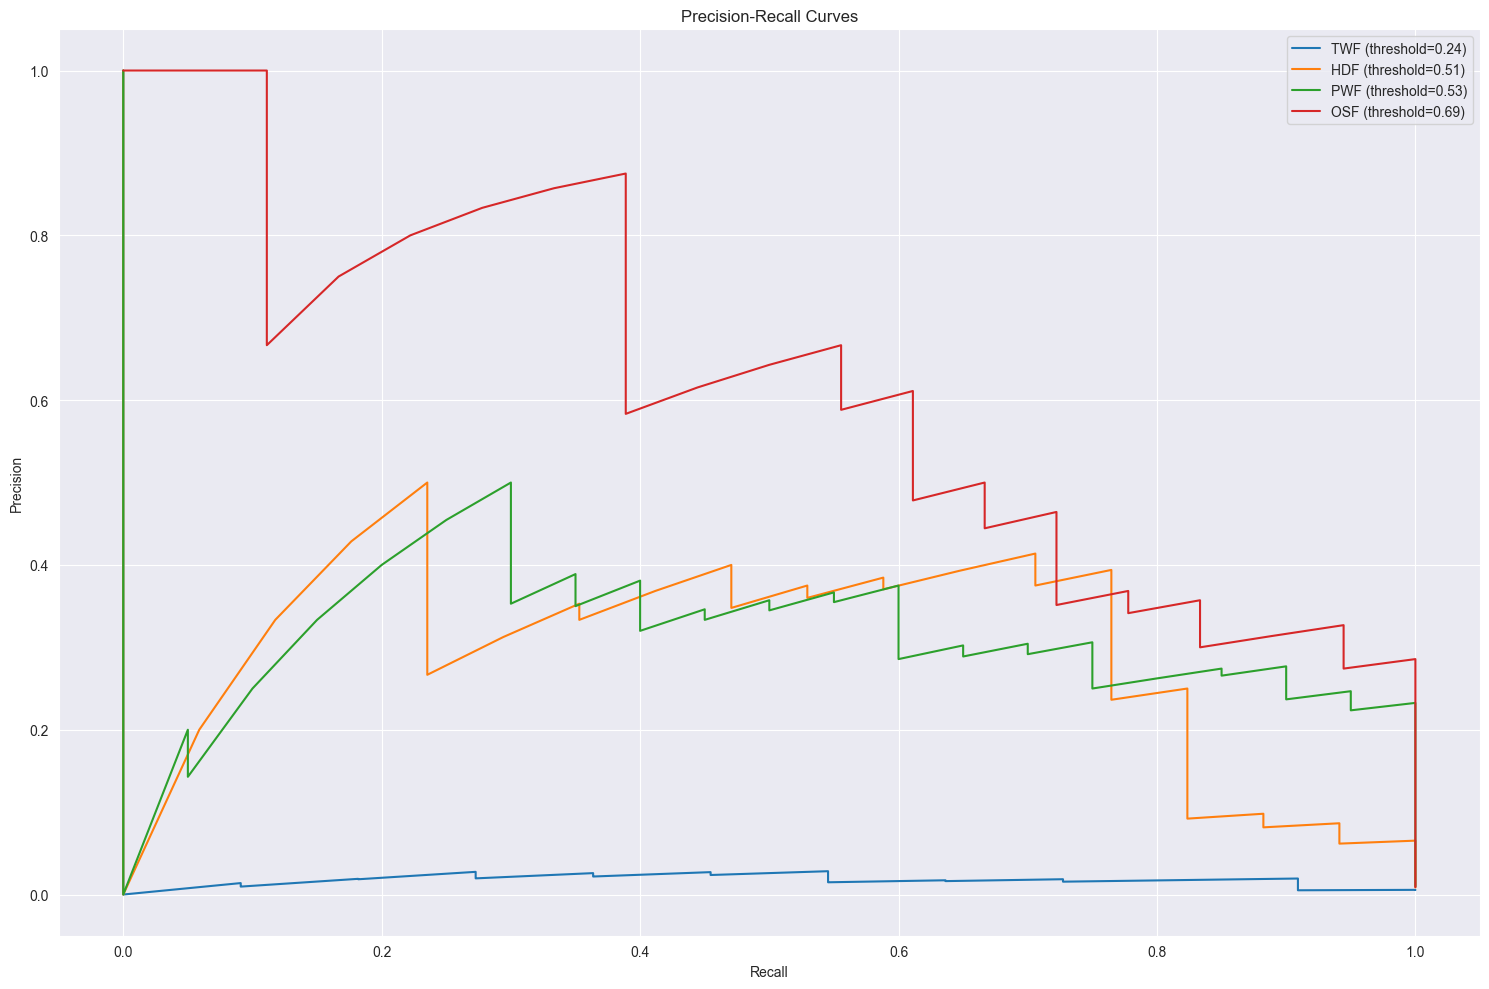

In [98]:
best_thresholds = plot_precision_recall_curves(voting_model,X_test_proc, y_test, targets)


# Hyperparameter tuning of the SOMTE resampled data for each of the selected models
We need to run a gird search on the already trained RandomForestClassier


In [99]:

# 1. Define a macro‐averaged recall scorer
scorer = make_scorer(recall_score, average='macro')

# 2. Wrap the base RandomForest in a MultiOutputClassifier
multi_rf = MultiOutputClassifier(
    RandomForestClassifier(random_state=42),
    n_jobs=-1
)

# 3. Specify the grid using the `estimator__` prefix
param_grid = {
    'estimator__n_estimators':      [100, 200, 300],
    'estimator__max_depth':         [10, 20, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf':  [1, 2, 4],
    'estimator__class_weight':      [None, 'balanced']
}

# 4. Set up the 5‐fold GridSearchCV
rf_grid = GridSearchCV(
    estimator=multi_rf,
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=2
)

# 5. Run the search on the SMOTE‐balanced training set
rf_grid.fit(X_train_resampled, y_train_resampled)

# 6. Inspect best hyperparameters
print("Best parameters for each underlying estimator:")
best_rf_parms ={key.replace('estimator__', ''): value for key, value in rf_grid.best_params_.items()}
print(best_rf_parms)
# 7. Grab the best MultiOutputClassifier
best_multi_rf = rf_grid.best_estimator_

# 8. Evaluate on the selected features / test split
results_rf = train_and_evaluate_model(
    best_multi_rf,
    X_train_clean,
    X_test_clean,
    y_train_resampled,
    y_test
)

print("\nRandom Forests (MultiOutput) Tuned Results:")
print(results_rf)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for each underlying estimator:
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Random Forests (MultiOutput) Tuned Results:
     Precision    Recall  F1-score
TWF   0.000000  0.000000  0.000000
HDF   0.200000  0.352941  0.255319
PWF   0.266667  0.400000  0.320000
OSF   0.310345  0.500000  0.382979


get the hyperparametes for LGBM

In [100]:
# 1) Define a base LGBM classifier
base_lgbm = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 2) Wrap in a MultiOutputClassifier for multi‐target support
multi_lgbm = MultiOutputClassifier(base_lgbm, n_jobs=-1)

# 3) Hyperparameter grid for LGBM
lgbm_grid = {
    'estimator__n_estimators':       [100, 200],
    'estimator__max_depth':          [-1, 10, 20],
    'estimator__learning_rate':      [0.01, 0.1],
    'estimator__num_leaves':         [31, 63],
    'estimator__subsample':          [0.8, 1.0],
    'estimator__colsample_bytree':   [0.8, 1.0]
}

# 4) Macro‐averaged recall scorer
scorer = make_scorer(recall_score, average='macro')

# 5) Grid search with 3‐fold CV
lgbm_grid_search = GridSearchCV(
    multi_lgbm,
    lgbm_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 6) Fit on your selected features
lgbm_grid_search.fit(X_train_selected, y_train)

# 7) Inspect the best hyperparameters
print("Best Parameters:")
best_lgbm_params = {key.replace('estimator__', ''): value for key, value in lgbm_grid_search.best_params_.items()}
print (best_lgbm_params)

# 8) Evaluate the best LGBM model
best_lgbm_model = lgbm_grid_search.best_estimator_
lgbm_results = train_and_evaluate_model(
    best_lgbm_model,
    X_train_clean,
    X_test_clean,
    y_train_resampled,
    y_test
)

print("\nLGBM Tuned Results:")
print(lgbm_results)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}

LGBM Tuned Results:
     Precision    Recall  F1-score
TWF   0.000000  0.000000  0.000000
HDF   0.681818  0.882353  0.769231
PWF   0.250000  0.250000  0.250000
OSF   0.478261  0.611111  0.536585


Now to get the hyperparameters for the catboost classifier

In [101]:

# 1) Instantiate a CatBoostClassifier for CPU
cat_cpu = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=False
)

# 2) Define a CPU‐only CatBoost base estimator
base_cb = CatBoostClassifier(
    task_type='CPU',       # CPU mode (default)
    random_seed=42,
    verbose=False          # silent training
)

# 3) Wrap in a MultiOutputClassifier for multi‐target support
multi_cpu_cb = MultiOutputClassifier(base_cb, n_jobs=-1)

# 4) Hyperparameter grid (CatBoost uses 'iterations', 'depth', 'subsample', 'rsm')
cat_grid = {
    'estimator__iterations':    [100, 200],
    'estimator__depth':         [6, 10],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__subsample':     [0.8, 1],
    'estimator__rsm':           [0.8, 1]
}

# 5) Macro recall scorer
scorer = make_scorer(recall_score, average='macro')

# 6) Grid search with 3‐fold CV
cat_grid_search = GridSearchCV(
    multi_cpu_cb,
    cat_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 7) Fit on your selected features
cat_grid_search.fit(X_train_selected, y_train)

print("Best Parameters:")
best_cat_params = {key.replace('estimator__', ''): value for key, value in cat_grid_search.best_params_.items()}
print (best_cat_params)

# 8) Evaluate the best model
best_cat_model = cat_grid_search.best_estimator_
results_cb = train_and_evaluate_model(
    best_cat_model,
    X_train_clean,
    X_test_clean,
    y_train_resampled,
    y_test
)

print("\nCatBoost Tuned Results:")
print(results_cb)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters:
{'depth': 6, 'iterations': 200, 'learning_rate': 0.1, 'rsm': 0.8, 'subsample': 1}

CatBoost Tuned Results:
     Precision    Recall  F1-score
TWF   0.000000  0.000000  0.000000
HDF   0.322581  0.588235  0.416667
PWF   0.235294  0.400000  0.296296
OSF   0.424242  0.777778  0.549020


Not to get the hyperparameters for the AdaBoost Classifier

In [102]:


# 1) Define a base AdaBoost classifier (CPU only)
base_ada = AdaBoostClassifier(random_state=42)

# 2) Wrap in a MultiOutputClassifier for multi‐target support
multi_ada = MultiOutputClassifier(base_ada, n_jobs=-1)

# 3) Hyperparameter grid for AdaBoost
param_grid = {
    'estimator__n_estimators':    [50, 100, 200],
    'estimator__learning_rate':   [0.01, 0.1, 1.0],
    'estimator__algorithm':       ['SAMME', 'SAMME.R']
}

# 4) Macro‐averaged recall scorer
scorer = make_scorer(recall_score, average='macro')

# 5) Grid search with 3‐fold CV
ada_grid = GridSearchCV(
    multi_ada,
    param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 6) Fit the grid on your selected features
ada_grid.fit(X_train_selected, y_train)

# 7) Inspect the best hyperparameters
print("Best Parameters:")
best_ada_params = {key.replace('estimator__', ''): value for key, value in ada_grid.best_params_.items()}
print(best_ada_params)

# 8) Evaluate the best AdaBoost model
best_ada_model = ada_grid.best_estimator_
ada_results = train_and_evaluate_model(
    best_ada_model,
    X_train_clean,
    X_test_clean,
    y_train_resampled,
    y_test
)

print("\nAdaBoost Tuned Results:")
print(ada_results)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters:
{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}

AdaBoost Tuned Results:
     Precision    Recall  F1-score
TWF   0.000000  0.000000  0.000000
HDF   0.106383  0.294118  0.156250
PWF   0.296296  0.800000  0.432432
OSF   0.215686  0.611111  0.318841


Hyperparameters for Logistic regression

In [103]:

# 1) Define a base Logistic Regression classifier
base_lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    n_jobs=-1
)

# 2) Wrap in a MultiOutputClassifier for multi‐target support
multi_lr = MultiOutputClassifier(base_lr, n_jobs=-1)

# 3) Hyperparameter grid for Logistic Regression
lr_grid = {
    'estimator__C':            [0.01, 0.1, 1, 10],
    'estimator__penalty':      ['l1', 'l2'],
    'estimator__solver':       ['liblinear'],
    'estimator__class_weight': [None, 'balanced']
}

# 4) Macro‐averaged recall scorer
scorer = make_scorer(recall_score, average='macro')

# 5) Grid search with 3‐fold CV
lr_grid_search = GridSearchCV(
    multi_lr,
    lr_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 6) Fit on your selected features
lr_grid_search.fit(X_train_selected, y_train)

# 7) Inspect the best hyperparameters
print("Best Parameters:")
best_lr_params= {key.replace('estimator__', ''): value for key, value in lr_grid_search.best_params_.items()}
print(best_lr_params)




# 8) Evaluate the best Logistic Regression model
best_lr_model = lr_grid_search.best_estimator_
lr_results = train_and_evaluate_model(
    best_lr_model,
    X_train_clean,
    X_test_clean,
    y_train_resampled,
    y_test
)

print("\nLogistic Regression Tuned Results:")
print(lr_results)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters:
{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression Tuned Results:
     Precision    Recall  F1-score
TWF   0.016026  0.454545  0.030960
HDF   0.033113  0.588235  0.062696
PWF   0.067114  1.000000  0.125786
OSF   0.057692  1.000000  0.109091


Now apply them to the Libary model

In [104]:

tuned_voting_model = MultiOutputClassifier(
    VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(**best_lr_params,max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(**best_rf_parms, random_state=42)),
            ('ada', AdaBoostClassifier(**best_ada_params, random_state=42)),
            ('cat', CatBoostClassifier(**best_cat_params,verbose=0, random_state=42)),
            ('lgbm', LGBMClassifier(**best_lgbm_params, random_state=42))
        ],
        voting='soft'  # use 'soft' to average predicted probabilities
    )
)

tuned_voting_results = train_and_evaluate_model(
    tuned_voting_model,
    X_train_clean,
    X_test_proc,
    y_train_resampled,
    y_test
)

print("\nVotingClassifier Ensemble Results:")
print(tuned_voting_results)





VotingClassifier Ensemble Results:
     Precision    Recall  F1-score
TWF   0.000000  0.000000  0.000000
HDF   0.407407  0.647059  0.500000
PWF   0.333333  0.600000  0.428571
OSF   0.406250  0.722222  0.520000


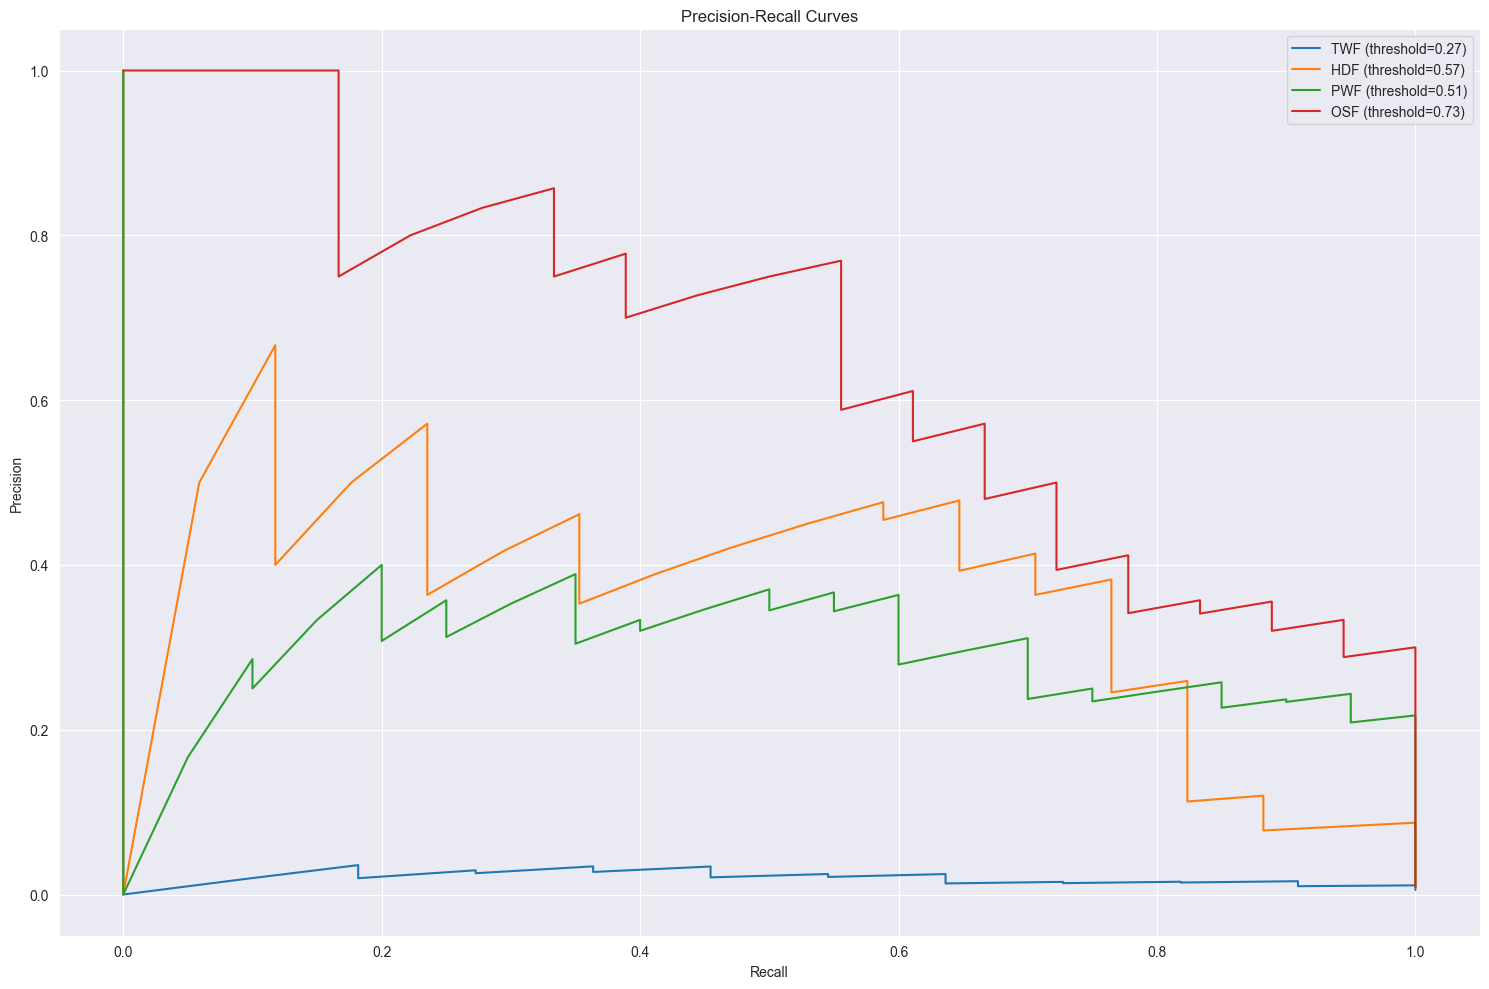

In [105]:
tuned_best_thresholds = plot_precision_recall_curves(tuned_voting_model,X_test_proc, y_test, targets)

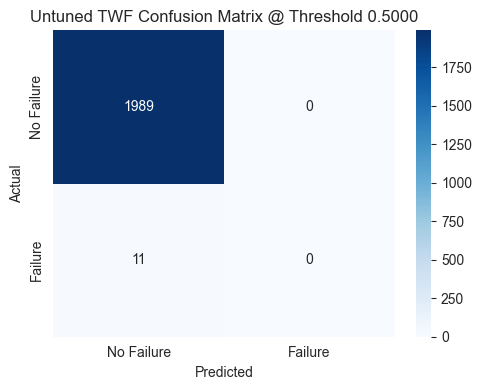

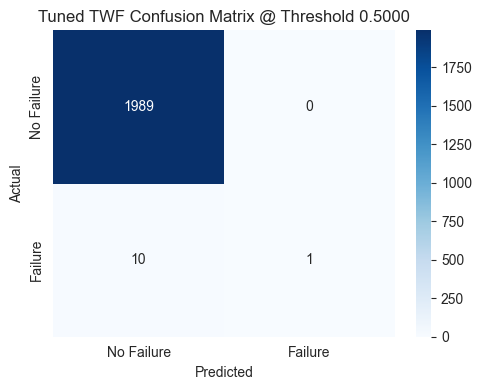

In [106]:

def draw_confusion_matrices_with_threshold(model, X_train_proc, y_train, X_test_proc, y_test, targets, thresholds_dict=None,filePrefix=""):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Fit the model
    model.fit(X_train_proc, y_train)

    # Predict probabilities
    y_proba = model.predict_proba(X_test_proc)

    # Set default thresholds if none provided
    if thresholds_dict is None:
        thresholds_dict = {target: 0.5 for target in targets}

    fig, axes = plt.subplots(1, len(targets), figsize=(5 * len(targets), 4))

    for i, target in enumerate(targets):
        # Get the threshold for this target
        threshold = thresholds_dict.get(target, 0.5)

        # Apply threshold to the probability of the 'Failure' class (index 1)
        y_pred_thresh = (y_proba[i][:, 1] >= threshold).astype(int)

        cm = confusion_matrix(y_test[target], y_pred_thresh)
        ax = axes[i] if len(targets) > 1 else axes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Failure', 'Failure'],
                    yticklabels=['No Failure', 'Failure'],
                    ax=ax)
        ax.set(title=f'{filePrefix} {target} Confusion Matrix @ Threshold {threshold:.4f}',
               xlabel='Predicted', ylabel='Actual')
        plt.tight_layout()
        plt.savefig(f'{filePrefix} Confusion Matrix_{target}_Threshold {threshold:.4f}.png', dpi=600, bbox_inches='tight')

    plt.show()



draw_confusion_matrices_with_threshold(voting_model, X_train_selected, y_train, X_test_selected, y_test, targets=['TWF'], filePrefix="Untuned")
draw_confusion_matrices_with_threshold(tuned_voting_model, X_train_selected, y_train, X_test_selected, y_test, targets=['TWF'], filePrefix="Tuned")


In [107]:

def evaluate_all_targets(model, X_test, y_test, targets=None, thresholds=None):


    if targets is None:
        targets = y_test.columns

    performance = {}

    # For multi-output model, predict_proba gives a list of arrays
    y_pred_proba_list = model.predict_proba(X_test)

    for i, target in enumerate(targets):
        y_true = y_test[target]

        # Get probabilities for this target
        y_pred_prob = y_pred_proba_list[i][:, 1]

        # Use custom threshold if provided, else default to 0.5
        threshold = thresholds.get(target, 0.5) if thresholds else 0.5
        y_pred = (y_pred_prob >= threshold).astype(int)

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        performance[target] = [precision, recall, f1]

    perf_df = pd.DataFrame(performance, index=["Precision", "Recall", "F1-score"]).T

    return perf_df

**test the model without hyperparameters,with hyperparameters and with hyperparameters and thresholds **

     Precision    Recall  F1-score
TWF   0.000000  0.000000  0.000000
HDF   1.000000  0.823529  0.903226
PWF   0.875000  0.700000  0.777778
OSF   0.928571  0.722222  0.812500


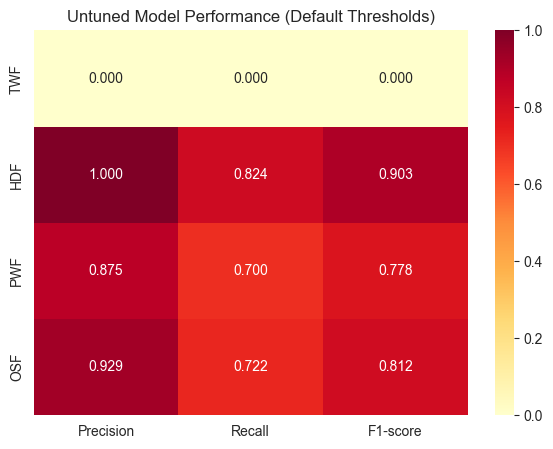

 Tuned Performance WITHOUT Custom Thresholds:
     Precision    Recall  F1-score
TWF   1.000000  0.090909  0.166667
HDF   0.941176  0.941176  0.941176
PWF   0.882353  0.750000  0.810811
OSF   0.866667  0.722222  0.787879


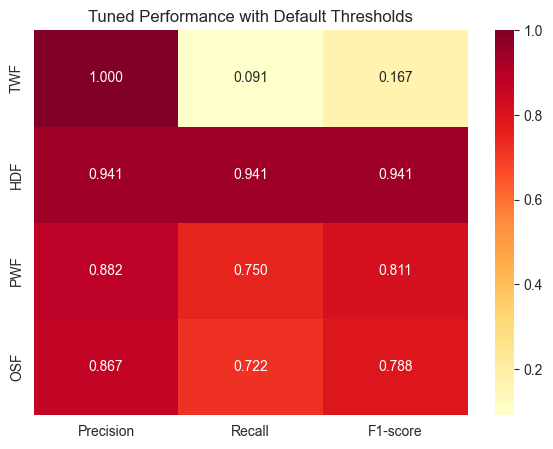

Tuned Model Performance WITH Optimal Thresholds:
     Precision    Recall  F1-score
TWF   0.084337  0.636364  0.148936
HDF   1.000000  0.941176  0.969697
PWF   0.875000  0.700000  0.777778
OSF   1.000000  0.611111  0.758621


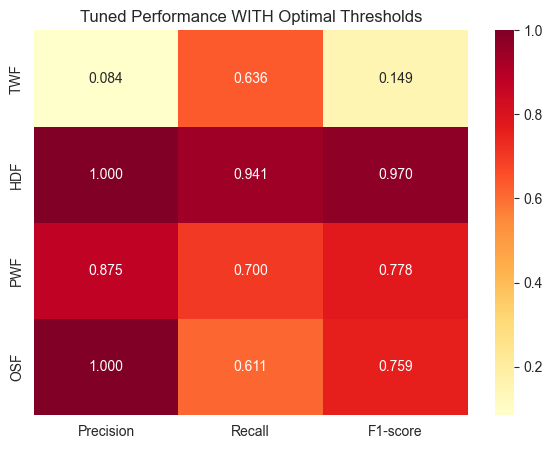

In [108]:
## test the model without hyperparameters

voting_model.fit(X_train_clean, y_train_clean)
y_pred_base = voting_model.predict(X_test_proc)
results_base = train_and_evaluate_model (voting_model, X_train_selected, X_test_selected, y_train, y_test, thresholds=None)
print(results_base)
plt.figure(figsize=(7, 5))
sns.heatmap(results_base, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Untuned Model Performance (Default Thresholds)')
plt.savefig('untuned_metrics_no_threshold_heatmap.png', dpi=600, bbox_inches='tight')
plt.show()

# Test the tuned model without hyperparameters
tuned_voting_model.fit(X_train_clean, y_train_clean)
y_pred_default = tuned_voting_model.predict(X_test_proc)
print(f" Tuned Performance WITHOUT Custom Thresholds:")
results_default = train_and_evaluate_model (tuned_voting_model, X_train_selected, X_test_selected, y_train, y_test, thresholds=None)
print(results_default)

plt.figure(figsize=(7, 5))
sns.heatmap(results_default, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Tuned Performance with Default Thresholds')
plt.savefig('Tuned_model_no_threshold_heatmap.png', dpi=600, bbox_inches='tight')  # Export to PNG
plt.show()


# Test the tuned model with hyperparameters
print(f"Tuned Model Performance WITH Optimal Thresholds:")
results_custom = train_and_evaluate_model(tuned_voting_model, X_train_selected, X_test_selected, y_train, y_test, thresholds=tuned_best_thresholds)
print(results_custom)


plt.figure(figsize=(7, 5))

# Default thresholds heatmap
sns.heatmap(results_custom, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Tuned Performance WITH Optimal Thresholds')
plt.savefig('Tuned_model_with_threshold_heatmap.png', dpi=600, bbox_inches='tight')  # Export to PNG
plt.show()

In [109]:

tuned_voting_model.fit(X_train_proc, y_train)

dump(tuned_voting_model, 'tuned_voting_ensemble_model.pkl')
print("Model saved to tuned_voting_ensemble_model.pkl")

Model saved to tuned_voting_ensemble_model.pkl


voting_model_results = train_and_evaluate_model(voting_model, X_train_selected, X_test_selected, y_train, y_test)
tuned_voting_model_results  = train_and_evaluate_model(tuned_voting_model, X_train_selected, X_test_selected, y_train, y_test)

print (f"voting model test results are \n {voting_model_results}")
plt.figure(figsize=(10, 6))
sns.heatmap(voting_model_results, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title("Untuned VotingClassifier Ensemble Performance")
plt.tight_layout()
plt.show()


print (f"Tuned voting model test results are \n {tuned_voting_model_results}")
plt.figure(figsize=(10, 6))
sns.heatmap(tuned_voting_model_results, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title("tuned VotingClassifier Ensemble Performance")
plt.tight_layout()
plt.show()


Recall is very low on the Test data as compared to the taining data for TWF

Need to define a better custom threshold for TWF to get better results the below function will sweep through threshold bewtween defined values in defined increments until an

In [110]:


def threshold_sweep_metrics(model, X_test_proc, y_test_target, target_name, start_point=0.0, end_point=1.0, step=0.01):
    model.fit(X_train_proc, y_train)

    # Get probabilities for just the specified target
    target_index = targets.index(target_name)
    y_proba_target = model.predict_proba(X_test_proc)[target_index][:, 1]

    thresholds = np.arange(start_point, end_point, step)
    precision_vals, recall_vals, f1_vals = [], [], []

    for thresh in thresholds:
        y_pred = (y_proba_target >= thresh).astype(int)

        precision_vals.append(precision_score(y_test_target, y_pred, zero_division=0))
        recall_vals.append(recall_score(y_test_target, y_pred, zero_division=0))
        f1_vals.append(f1_score(y_test_target, y_pred, zero_division=0))
        #Identify Sweet Spot
    best_index = np.argmax(f1_vals)
    best_threshold = thresholds[best_index]
    print(f" Best threshold for {target_name} by F1 score: {best_threshold:.4f}")


    # 🖼 Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_vals, label='Precision', linestyle='--')
    plt.plot(thresholds, recall_vals, label='Recall', linestyle='-')
    plt.plot(thresholds, f1_vals, label='F1 Score', linestyle='-.')
    plt.axvline(x=tuned_best_thresholds[target_name], color='r', linestyle=':', label=f"Best Threshold: {best_threshold:.4f}")
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{target_name} Performance Across Thresholds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return best_threshold




We need to refine the best Threshold for TWF so sweep through the possible thresholds
function details as low point of 0.0, a high point of 1.0 in increments of 0.01

In [111]:
print (f"Best Thresholds Before fine_tuning are {tuned_best_thresholds} ")
orig_thresholds = tuned_best_thresholds

Best Thresholds Before fine_tuning are {'TWF': 0.2721837173092251, 'HDF': 0.567996356322399, 'PWF': 0.5139855938768847, 'OSF': 0.7273999952246316} 


 Best threshold for TWF by F1 score: 0.3300


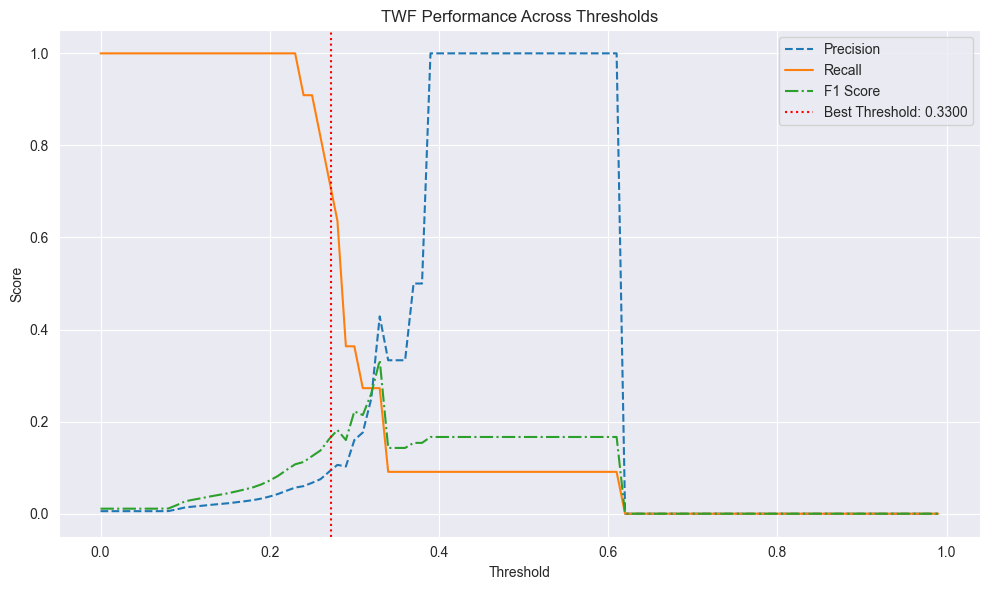

 Best threshold for TWF by F1 score: 0.3288


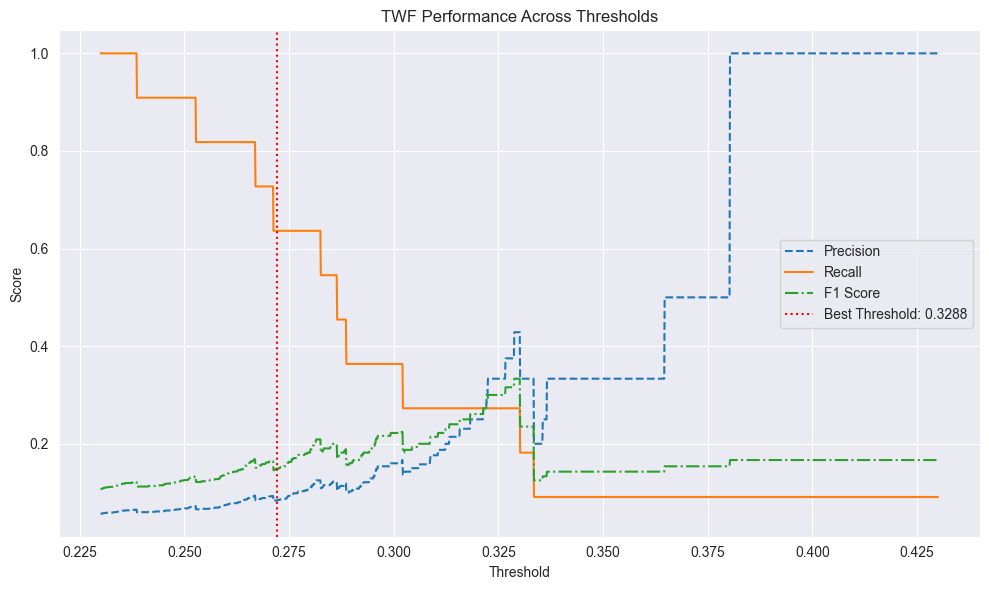

In [112]:
best_twf_thresh = threshold_sweep_metrics(
    model=tuned_voting_model,
    X_test_proc=X_test_selected,
    y_test_target=y_test['TWF'],
    target_name='TWF'
)
#  We now have an estimate of where the threshold is, now we override the default start point,
#  end point and step to refine it even further so now we go between +/- 0.1 of the current best threshold  in steps of 0.0001

best_twf_thresh = threshold_sweep_metrics(
    model=tuned_voting_model,
    X_test_proc=X_test_selected,
    y_test_target=y_test['TWF'],
    target_name='TWF',
    start_point=best_twf_thresh - 0.10,
    end_point=best_twf_thresh + 0.10,
    step = 0.0001
)

Get the Best Thresholds for the other targets

 Best threshold for HDF by F1 score: 0.5100


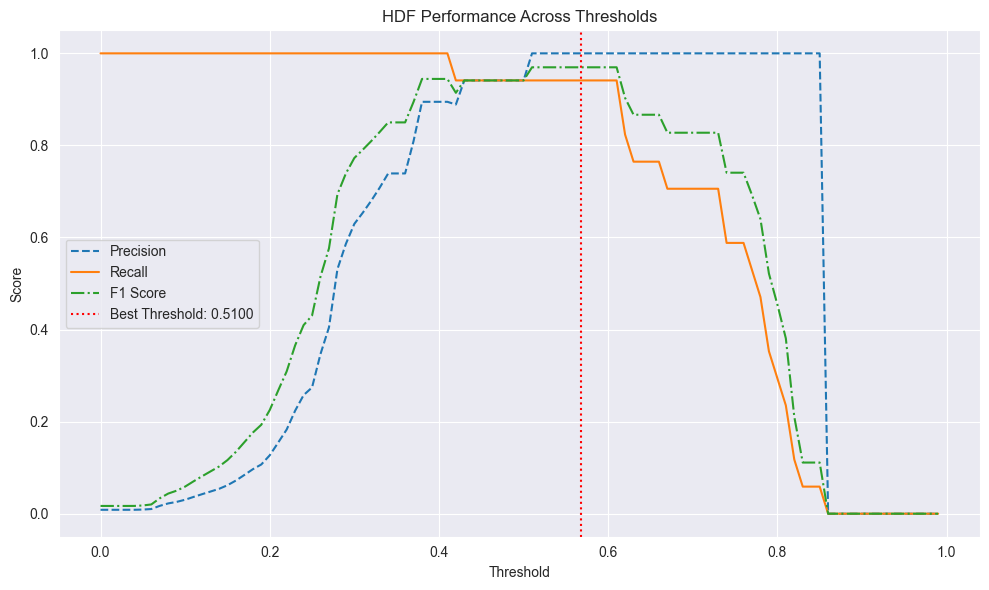

 Best threshold for HDF by F1 score: 0.3773


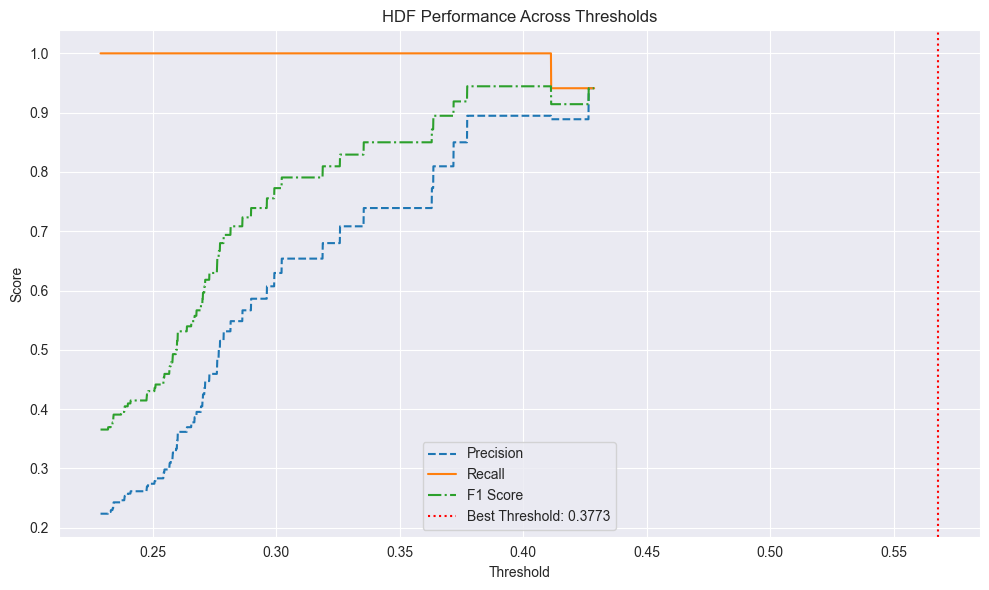

In [113]:
best_hdf_thresh = threshold_sweep_metrics(
    model=tuned_voting_model,
    X_test_proc=X_test_selected,
    y_test_target=y_test['HDF'],
    target_name='HDF'
)
best_hdf_thresh = threshold_sweep_metrics(
    model=tuned_voting_model,
    X_test_proc=X_test_selected,
    y_test_target=y_test['HDF'],
    target_name='HDF',
    start_point=best_twf_thresh - 0.10,
    end_point=best_twf_thresh + 0.10,
    step = 0.0001
)

 Best threshold for PWF by F1 score: 0.3400


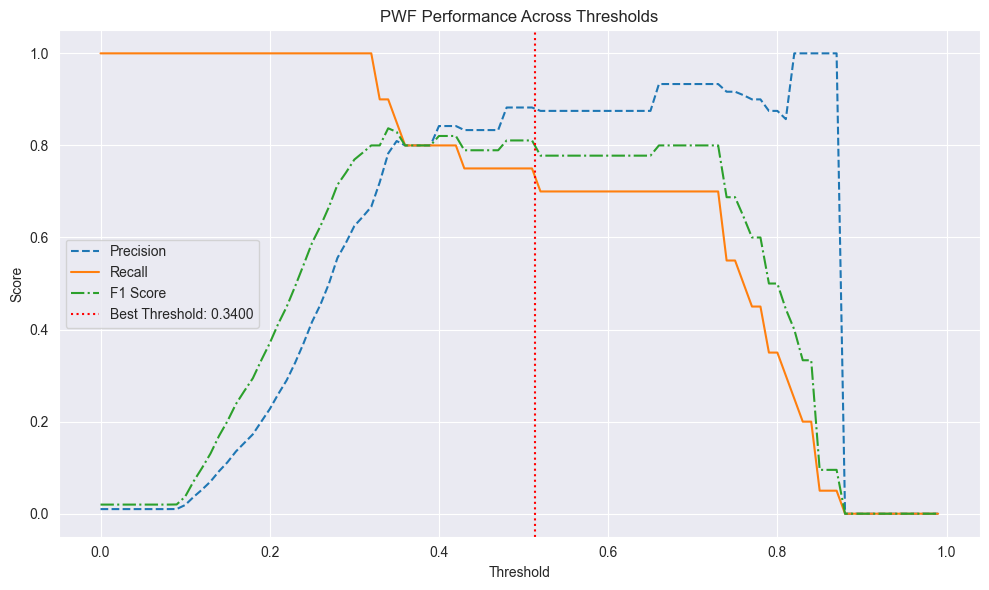

 Best threshold for PWF by F1 score: 0.3395


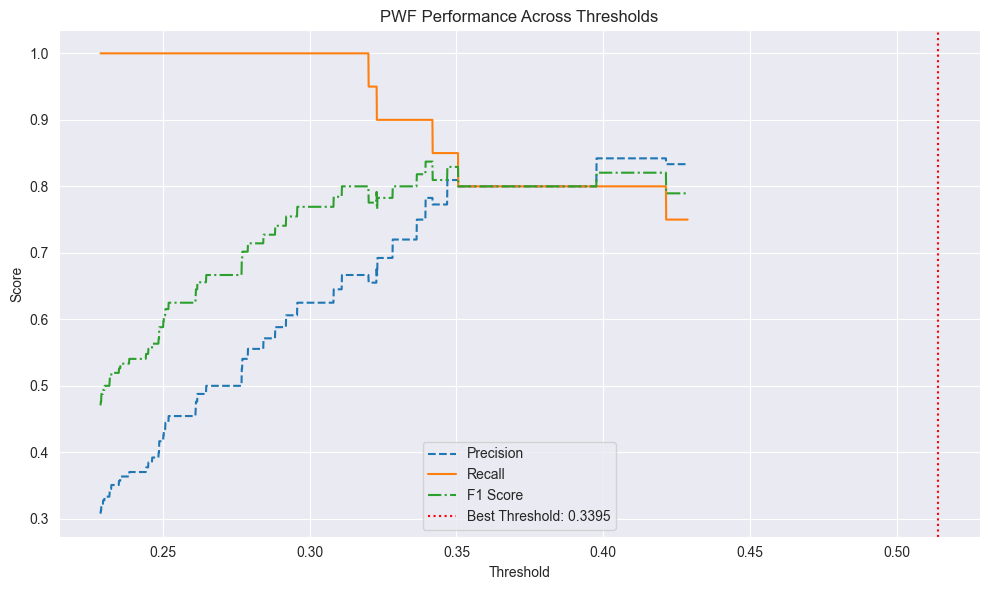

In [114]:
best_pwf_thresh = threshold_sweep_metrics(
    model=tuned_voting_model,
    X_test_proc=X_test_selected,
    y_test_target=y_test['PWF'],
    target_name='PWF'
)
best_pwf_thresh = threshold_sweep_metrics(
    model=tuned_voting_model,
    X_test_proc=X_test_selected,
    y_test_target=y_test['PWF'],
    target_name='PWF',
    start_point=best_twf_thresh - 0.10,
    end_point=best_twf_thresh + 0.10,
    step = 0.0001
)

 Best threshold for OSF by F1 score: 0.3400


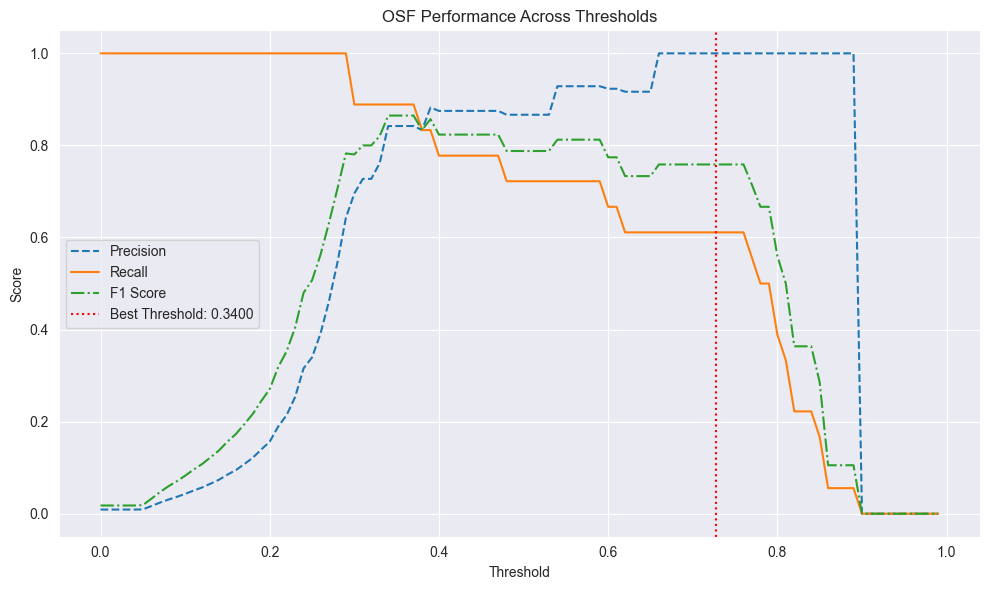

 Best threshold for OSF by F1 score: 0.3356


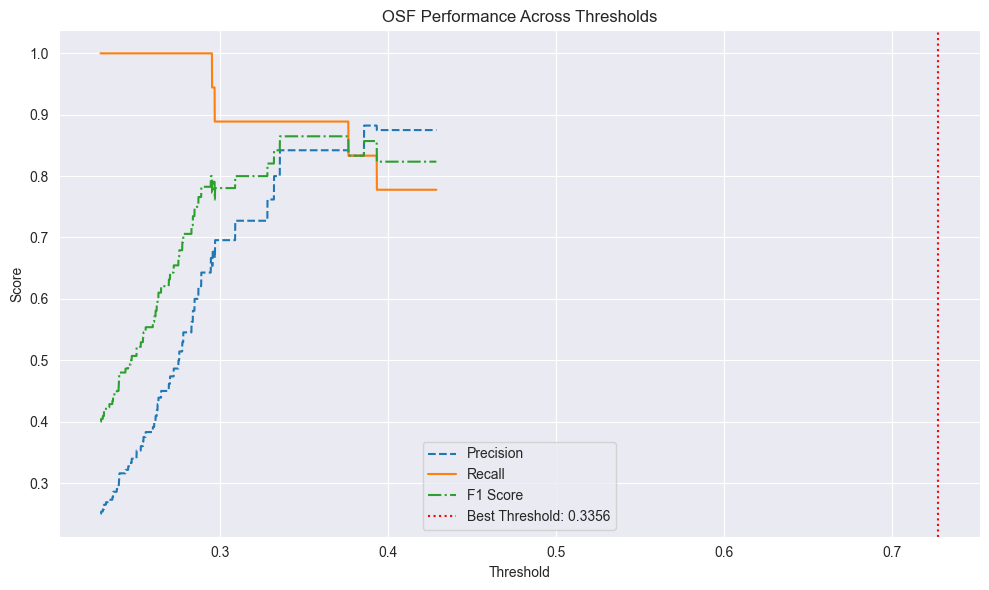

In [115]:
best_osf_thresh = threshold_sweep_metrics(
    model=tuned_voting_model,
    X_test_proc=X_test_selected,
    y_test_target=y_test['OSF'],
    target_name='OSF'
)
best_osf_thresh = threshold_sweep_metrics(
    model=tuned_voting_model,
    X_test_proc=X_test_selected,
    y_test_target=y_test['OSF'],
    target_name='OSF',
    start_point=best_twf_thresh - 0.10,
    end_point=best_twf_thresh + 0.10,
    step = 0.0001
)

In [116]:


def evaluate_all_targets(model, X_test, y_test, targets=None, thresholds=None):


    if targets is None:
        targets = y_test.columns

    performance = {}

    # For multi-output model, predict_proba gives a list of arrays
    y_pred_proba_list = model.predict_proba(X_test)

    for i, target in enumerate(targets):
        y_true = y_test[target]

        # Get probabilities for this target
        y_pred_prob = y_pred_proba_list[i][:, 1]

        # Use custom threshold if provided, else default to 0.5
        threshold = thresholds.get(target, 0.5) if thresholds else 0.5
        y_pred = (y_pred_prob >= threshold).astype(int)

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        performance[target] = [precision, recall, f1]

    perf_df = pd.DataFrame(performance, index=["Precision", "Recall", "F1-score"]).T

    return perf_df

Replace the Threshold values in the Best Threshold dictionary with the refined values we determined and evaluate the model with the new thresholds

In [117]:
print (f"Best Thresholds Before fine_tuning are {orig_thresholds} ")

tuned_best_thresholds['TWF'] = np.float64(best_twf_thresh)
tuned_best_thresholds['HDF'] = np.float64(best_hdf_thresh)
tuned_best_thresholds['PWF'] = np.float64(best_pwf_thresh)
tuned_best_thresholds['OSF'] = np.float64(best_osf_thresh)

print (f"Best Thresholds after fine_tuning are {tuned_best_thresholds} ")

Best Thresholds Before fine_tuning are {'TWF': 0.2721837173092251, 'HDF': 0.567996356322399, 'PWF': 0.5139855938768847, 'OSF': 0.7273999952246316} 
Best Thresholds after fine_tuning are {'TWF': 0.3287999999999891, 'HDF': 0.37729999999997277, 'PWF': 0.33949999999997693, 'OSF': 0.33559999999997736} 


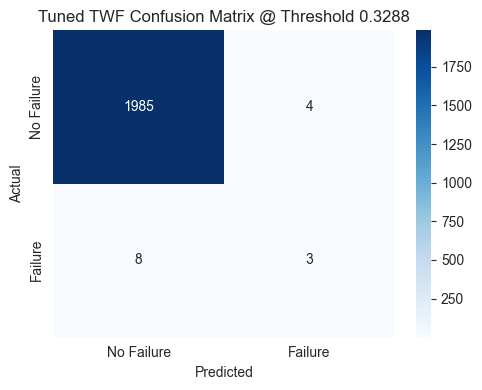

In [118]:
draw_confusion_matrices_with_threshold(tuned_voting_model, X_train_selected, y_train, X_test_selected, y_test,
                                       targets=['TWF'], thresholds_dict=tuned_best_thresholds,filePrefix ="Tuned")

Plot the heatmap of the updated thresholds on the test data

     Precision    Recall  F1-score
TWF   0.428571  0.272727  0.333333
HDF   0.894737  1.000000  0.944444
PWF   0.782609  0.900000  0.837209
OSF   0.842105  0.888889  0.864865
Tuned Model Performance WITH Updated Thresholds:


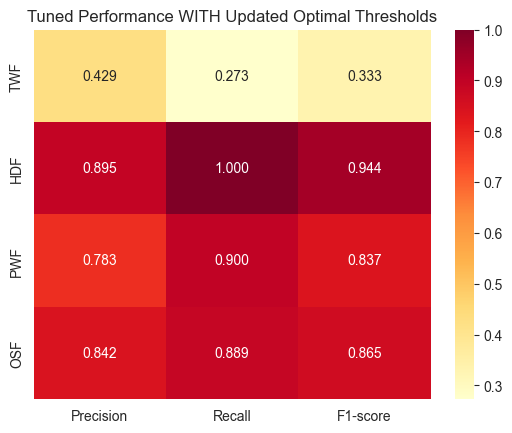

<Figure size 1000x600 with 0 Axes>

In [119]:
eval_results = train_and_evaluate_model(tuned_voting_model, X_train_selected, X_test_selected, y_train, y_test, thresholds=tuned_best_thresholds)

print(eval_results)

print("Tuned Model Performance WITH Updated Thresholds:")
# Create heatmaps for default and custom threshold results
# Default thresholds heatmap
sns.heatmap(eval_results, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Tuned Performance WITH Updated Optimal Thresholds')
plt.savefig('Final_Tuned_model_heatmap.png', dpi=600, bbox_inches='tight')
plt.figure(figsize=(10, 6))
plt.show()


In [120]:
# Export the model and thresholds



joblib.dump(tuned_voting_model, "tuned_voting_model.pkl")
with open("tuned_best_thresholds.json", "w") as f:
    json.dump(tuned_best_thresholds, f)



Rank how each feature influences outcomes for target

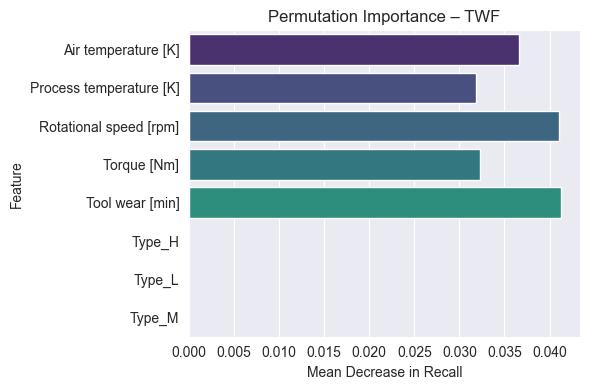

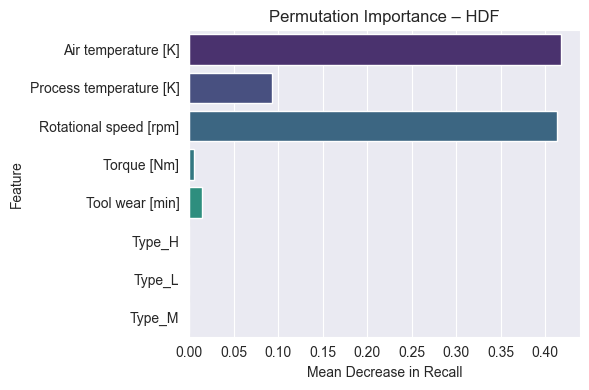

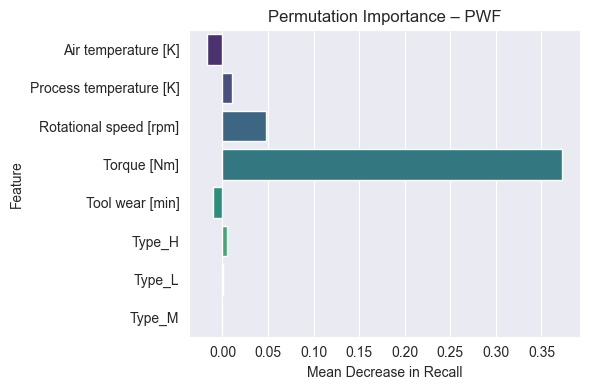

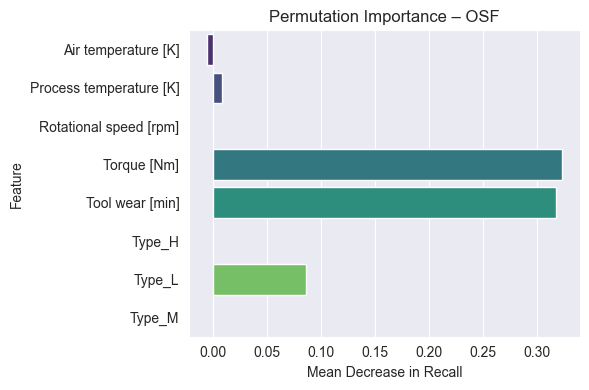

In [121]:


for i, target in enumerate(targets):
    # 1) extract the i-th fitted VotingClassifier
    single_clf = tuned_voting_model.estimators_[i]


   # run permutation importance on the model and each target
    pi = permutation_importance(
        single_clf,
        X_test_proc,
        y_test[target].values,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        scoring='recall_macro'

    )

    # build a DataFrame of that mean importance's
    imp_df = (
        pd.DataFrame({
            'feature':    modelFeatureNames,
            'importance': pi.importances_mean
        })
        .set_index('feature')
        .reindex(modelFeatureNames)
        .reset_index()

    )

    # plot importance of features on each target
    plt.figure(figsize=(6,4))
    sns.barplot(
        data=imp_df,
        x='importance',
        y='feature',
        palette='viridis'
    )
    plt.title(f'Permutation Importance – {target}')
    plt.xlabel("Mean Decrease in Recall")
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(f'Permutation Importance – {target}.png',dpi=600,bbox_inches='tight')
    plt.show()


Possible targets are ['TWF', 'HDF', 'PWF', 'OSF']

Power Failure (TWF) Prediction:
  Prediction:  No Failure
  Probability: 0.101
  Threshold:   0.329


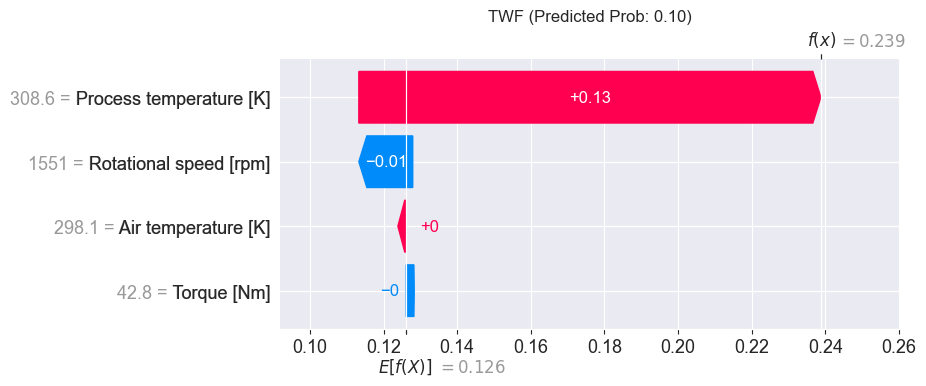

<Figure size 640x480 with 0 Axes>

In [122]:
# 1) Display possible targets
print(f"Possible targets are {targets}")

# 2) Prediction helper
def predict_pwf(model, input_data, target_index, threshold, features):
    X = pd.DataFrame([input_data], columns=features)
    probas = model.predict_proba(X)
    # handle the list-of-arrays vs single-array case
    pwf_prob = (
        probas[target_index][:, 1][0]
        if isinstance(probas, list)
        else probas[:, 1][0]
    )
    return {
        'Prediction': int(pwf_prob >= threshold),
        'Probability': pwf_prob,
        'Threshold': threshold
    }

# 3) Your simulated user input
custom_input = {
    'Air temperature [K]':      298.1,
    'Process temperature [K]':  308.6,
    'Rotational speed [rpm]':   1551,
    'Torque [Nm]':              42.8,
    'Tool wear [min]':          0.01,
    'Type_H':                   0,
    'Type_M':                   1,
    'Type_L':                   0
}

# 4) Choose which target to explain
selected_target = 'TWF'
target_index    = targets.index(selected_target)
threshold       = tuned_best_thresholds[selected_target]

# 5) Run a single prediction
result = predict_pwf(
    tuned_voting_model,
    custom_input,
    target_index,
    threshold,
    modelFeatureNames
)

print(f"\nPower Failure ({selected_target}) Prediction:")
print(f"  Prediction:  {'Failure' if result['Prediction'] else 'No Failure'}")
print(f"  Probability: {result['Probability']:.3f}")
print(f"  Threshold:   {result['Threshold']:.3f}")

# 6) Prepare the example for SHAP
X_custom = pd.DataFrame([custom_input], columns=modelFeatureNames)

def stacked_proba(X):
    """
    Returns an (n_samples, n_targets) array of positive-class probs
    """
    probs = tuned_voting_model.predict_proba(X)
    if isinstance(probs, list):
        # one array per target
        return np.column_stack([p[:, 1] for p in probs])
    return probs

# 7) Build a model-agnostic explainer
explainer = shap.Explainer(
    stacked_proba,
    X_train_proc,
    feature_names = modelFeatureNames,
    output_names  = targets,
    algorithm     = "auto"
)

# 8) Compute SHAP values on your single input
explanation = explainer(X_custom)

# 9) Extract the slice for your chosen target
vals_j = explanation.values[0, target_index, :]     # shape = (n_features,)
base_j = explanation.base_values[0, target_index]   # scalar
data_j = explanation.data[0]                        # shape = (n_features,)

# 10) Wrap into a single‐target Explanation and plot
exp_j = shap.Explanation(
    values       = vals_j,
    base_values  = base_j,
    data         = data_j,
    feature_names= modelFeatureNames
)

plt.title(f"{selected_target} (Predicted Prob: {result['Probability']:.2f})")
shap.plots.waterfall(exp_j, max_display=10)
plt.tight_layout()
plt.show()

In [123]:
end = time.time()

def convert_seconds(total_seconds):
    minutes = total_seconds // 60
    seconds = total_seconds % 60
    return minutes, seconds


time_in_seconds = end - start

minutes, seconds = convert_seconds(time_in_seconds)
print(f"Execution time: {minutes} minutes and  {seconds:.4f} seconds")


Execution time: 21.0 minutes and  56.3726 seconds
